<a href="https://colab.research.google.com/github/tanjirultusher/ChestXray-Pneumonia-Detection-Using-PyTorch/blob/main/Chest_X_ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# **PyTorch Chest X-ray Classification Code**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Define Custom Dataset Class**

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_resize = 150

class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform

        for label in labels:
            path = os.path.join(root_dir, label)
            class_num = labels.index(label)

            for img_name in os.listdir(path):
                try:
                    if img_name.endswith('jpeg'):
                        img_path = os.path.join(path, img_name)
                        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        resized_arr = cv2.resize(img_arr, (img_resize, img_resize))
                        self.data.append((resized_arr, class_num))
                except Exception as e:
                    print(f"Error loading image {img_name}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Define Transforms**

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_resize, img_resize)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_resize, img_resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# **Load Dataset**

In [ ]:
train_dataset = XRayDataset('/content/drive/MyDrive/datasets/chest_xray/train', transform=train_transform)
test_dataset = XRayDataset('/content/drive/MyDrive/datasets/chest_xray/test', transform=val_test_transform)


# **Train/Validation Split**

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# **DataLoaders**

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Define CNN Model**


In [ ]:
class ChestXRayCNN(nn.Module):
    def __init__(self):
        super(ChestXRayCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

# **Initialize Model**


In [ ]:
model = ChestXRayCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ChestXRayCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Dropout(p=0.2, inplac

# **Loss, Optimizer, Scheduler**

In [ ]:
desired_lr = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=desired_lr)
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, verbose=True, min_lr=1e-6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Training Loop**

In [ ]:
num_epochs = 18
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)


Epoch [1/18], Loss: 17.8757, Val Accuracy: 0.7841
Epoch [2/18], Loss: 0.3082, Val Accuracy: 0.9119
Epoch [3/18], Loss: 0.2409, Val Accuracy: 0.9242
Epoch [4/18], Loss: 0.2122, Val Accuracy: 0.8854
Epoch [5/18], Loss: 0.1955, Val Accuracy: 0.9242
Epoch [6/18], Loss: 0.1681, Val Accuracy: 0.9508
Epoch [7/18], Loss: 0.1435, Val Accuracy: 0.9583
Epoch [8/18], Loss: 0.1398, Val Accuracy: 0.9669
Epoch [9/18], Loss: 0.1370, Val Accuracy: 0.9640
Epoch [10/18], Loss: 0.1242, Val Accuracy: 0.9564
Epoch [11/18], Loss: 0.1237, Val Accuracy: 0.9583
Epoch [12/18], Loss: 0.0941, Val Accuracy: 0.9735
Epoch [13/18], Loss: 0.0858, Val Accuracy: 0.9735
Epoch [14/18], Loss: 0.0866, Val Accuracy: 0.9754
Epoch [15/18], Loss: 0.0794, Val Accuracy: 0.9688
Epoch [16/18], Loss: 0.0810, Val Accuracy: 0.9688
Epoch [17/18], Loss: 0.0750, Val Accuracy: 0.9773
Epoch [18/18], Loss: 0.0824, Val Accuracy: 0.9716


# **Test Set Evaluation**

In [ ]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc = correct / total
print(f"\n Test Accuracy: {test_acc:.4f}")


 Test Accuracy: 0.8574


Classification Report & Confusion Matrix

 Confusion Matrix:


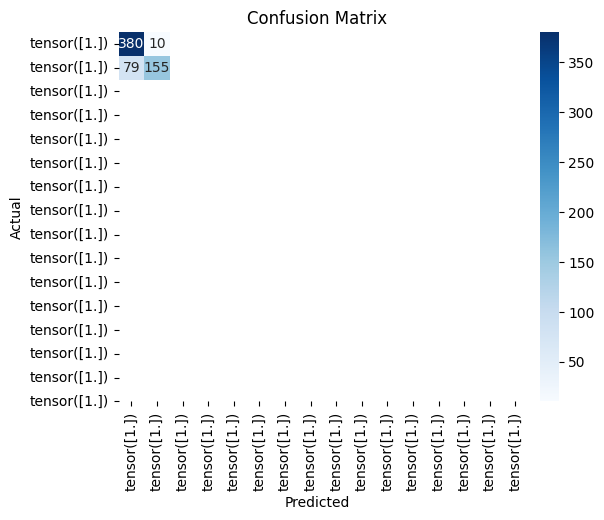

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# print("\n Classification Report:")
# print(classification_report(y_true, y_pred, target_names=labels))

print(" Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

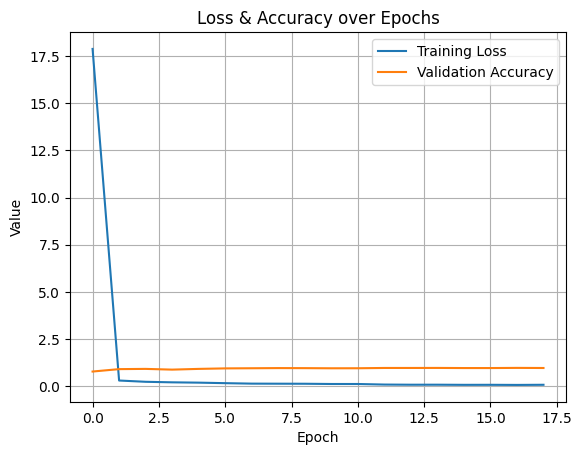

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss & Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'xray_model.pth')


In [ ]:
def predict_image(image_path, model, transform, device):
    model.eval()
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (150, 150))
    img = transform(img).unsqueeze(0).to(device)  # [1, 1, 150, 150]

    with torch.no_grad():
        output = model(img)
        pred = (output > 0.5).item()

    return labels[int(pred)]


In [ ]:
!ls /content

drive  sample_data  xray_model.pth


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/datasets/chest_xray/xray_model.pth')
